# HAR CNN training 

In [1]:
# Imports
import numpy as np
import os
from utils.utilities import *
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

## Prepare data

In [3]:
%ls ../../data/har-data/train/Inertial_Signals/

body_acc_x_train.txt*  body_gyro_x_train.txt*  total_acc_x_train.txt*
body_acc_y_train.txt*  body_gyro_y_train.txt*  total_acc_y_train.txt*
body_acc_z_train.txt*  body_gyro_z_train.txt*  total_acc_z_train.txt*


In [5]:
X_train, labels_train, list_ch_train = read_data(data_path="../../data/har-data/", split="train") # train
X_test, labels_test, list_ch_test = read_data(data_path="../../data/har-data/", split="test") # test

assert list_ch_train == list_ch_test, "Mistmatch in channels!"

In [6]:
# Normalize?
X_train, X_test = standardize(X_train, X_test)

Train/Validation Split

In [7]:
X_tr, X_vld, lab_tr, lab_vld = train_test_split(X_train, labels_train, 
                                                stratify = labels_train, random_state = 123)

One-hot encoding:

In [8]:
y_tr = one_hot(lab_tr)
y_vld = one_hot(lab_vld)
y_test = one_hot(labels_test)

In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Hyperparameters

In [10]:
batch_size = 600       # Batch size
seq_len = 128          # Number of steps
learning_rate = 0.0001
epochs = 1000

n_classes = 6
n_channels = 9

### Construct the graph
Placeholders

In [11]:
graph = tf.Graph()

# Construct placeholders
with graph.as_default():
    inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs')
    labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels')
    keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
    learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')

Build Convolutional Layers

Note: Should we use a different activation? Like tf.nn.tanh?

In [12]:
with graph.as_default():
    # (batch, 128, 9) --> (batch, 64, 18)
    conv1 = tf.layers.conv1d(inputs=inputs_, filters=18, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=2, strides=2, padding='same')
    
    # (batch, 64, 18) --> (batch, 32, 36)
    conv2 = tf.layers.conv1d(inputs=max_pool_1, filters=36, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_2 = tf.layers.max_pooling1d(inputs=conv2, pool_size=2, strides=2, padding='same')
    
    # (batch, 32, 36) --> (batch, 16, 72)
    conv3 = tf.layers.conv1d(inputs=max_pool_2, filters=72, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_3 = tf.layers.max_pooling1d(inputs=conv3, pool_size=2, strides=2, padding='same')
    
    # (batch, 16, 72) --> (batch, 8, 144)
    conv4 = tf.layers.conv1d(inputs=max_pool_3, filters=144, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_4 = tf.layers.max_pooling1d(inputs=conv4, pool_size=2, strides=2, padding='same')

Now, flatten and pass to the classifier

In [13]:
with graph.as_default():
    # Flatten and add dropout
    flat = tf.reshape(max_pool_4, (-1, 8*144))
    flat = tf.nn.dropout(flat, keep_prob=keep_prob_)
    
    # Predictions
    logits = tf.layers.dense(flat, n_classes)
    
    # Cost function and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))
    optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost)
    
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

### Train the network

In [14]:
if (os.path.exists('checkpoints-cnn') == False):
    !mkdir checkpoints-cnn

In [15]:
validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
   
    # Loop over epochs
    for e in range(epochs):
        
        # Loop over batches
        for x,y in get_batches(X_tr, y_tr, batch_size):
            
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, keep_prob_ : 0.5, learning_rate_ : learning_rate}
            
            # Loss
            loss, _ , acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            # Print at each 5 iters
            if (iteration % 5 == 0):
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Train loss: {:6f}".format(loss),
                      "Train acc: {:.6f}".format(acc))
            
            # Compute validation loss at every 10 iterations
            if (iteration%10 == 0):                
                val_acc_ = []
                val_loss_ = []
                
                for x_v, y_v in get_batches(X_vld, y_vld, batch_size):
                    # Feed
                    feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0}  
                    
                    # Loss
                    loss_v, acc_v = sess.run([cost, accuracy], feed_dict = feed)                    
                    val_acc_.append(acc_v)
                    val_loss_.append(loss_v)
                
                # Print info
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Validation loss: {:6f}".format(np.mean(val_loss_)),
                      "Validation acc: {:.6f}".format(np.mean(val_acc_)))
                
                # Store
                validation_acc.append(np.mean(val_acc_))
                validation_loss.append(np.mean(val_loss_))
            
            # Iterate 
            iteration += 1
    
    saver.save(sess,"checkpoints-cnn/har.ckpt")

Epoch: 0/1000 Iteration: 5 Train loss: 1.737945 Train acc: 0.170000
Epoch: 1/1000 Iteration: 10 Train loss: 1.687642 Train acc: 0.226667
Epoch: 1/1000 Iteration: 10 Validation loss: 1.653402 Validation acc: 0.359444
Epoch: 1/1000 Iteration: 15 Train loss: 1.651793 Train acc: 0.255000
Epoch: 2/1000 Iteration: 20 Train loss: 1.581353 Train acc: 0.315000
Epoch: 2/1000 Iteration: 20 Validation loss: 1.570219 Validation acc: 0.373889
Epoch: 2/1000 Iteration: 25 Train loss: 1.568358 Train acc: 0.301667
Epoch: 3/1000 Iteration: 30 Train loss: 1.542235 Train acc: 0.305000
Epoch: 3/1000 Iteration: 30 Validation loss: 1.496469 Validation acc: 0.382778
Epoch: 3/1000 Iteration: 35 Train loss: 1.510998 Train acc: 0.311667
Epoch: 4/1000 Iteration: 40 Train loss: 1.469710 Train acc: 0.341667
Epoch: 4/1000 Iteration: 40 Validation loss: 1.426502 Validation acc: 0.395556
Epoch: 4/1000 Iteration: 45 Train loss: 1.459547 Train acc: 0.345000
Epoch: 5/1000 Iteration: 50 Train loss: 1.376798 Train acc: 0.36

Epoch: 42/1000 Iteration: 385 Train loss: 0.234431 Train acc: 0.921667
Epoch: 43/1000 Iteration: 390 Train loss: 0.248555 Train acc: 0.903333
Epoch: 43/1000 Iteration: 390 Validation loss: 0.193027 Validation acc: 0.927222
Epoch: 43/1000 Iteration: 395 Train loss: 0.187847 Train acc: 0.936667
Epoch: 44/1000 Iteration: 400 Train loss: 0.216255 Train acc: 0.908333
Epoch: 44/1000 Iteration: 400 Validation loss: 0.186277 Validation acc: 0.931667
Epoch: 44/1000 Iteration: 405 Train loss: 0.212257 Train acc: 0.938333
Epoch: 45/1000 Iteration: 410 Train loss: 0.215412 Train acc: 0.933333
Epoch: 45/1000 Iteration: 410 Validation loss: 0.181315 Validation acc: 0.930000
Epoch: 46/1000 Iteration: 415 Train loss: 0.200837 Train acc: 0.926667
Epoch: 46/1000 Iteration: 420 Train loss: 0.179654 Train acc: 0.938333
Epoch: 46/1000 Iteration: 420 Validation loss: 0.176274 Validation acc: 0.933889
Epoch: 47/1000 Iteration: 425 Train loss: 0.197167 Train acc: 0.936667
Epoch: 47/1000 Iteration: 430 Train l

Epoch: 84/1000 Iteration: 760 Train loss: 0.151102 Train acc: 0.930000
Epoch: 84/1000 Iteration: 760 Validation loss: 0.121150 Validation acc: 0.946111
Epoch: 84/1000 Iteration: 765 Train loss: 0.141005 Train acc: 0.946667
Epoch: 85/1000 Iteration: 770 Train loss: 0.127195 Train acc: 0.953333
Epoch: 85/1000 Iteration: 770 Validation loss: 0.120506 Validation acc: 0.945000
Epoch: 86/1000 Iteration: 775 Train loss: 0.121173 Train acc: 0.943333
Epoch: 86/1000 Iteration: 780 Train loss: 0.115722 Train acc: 0.948333
Epoch: 86/1000 Iteration: 780 Validation loss: 0.120012 Validation acc: 0.946111
Epoch: 87/1000 Iteration: 785 Train loss: 0.128091 Train acc: 0.950000
Epoch: 87/1000 Iteration: 790 Train loss: 0.135934 Train acc: 0.948333
Epoch: 87/1000 Iteration: 790 Validation loss: 0.119682 Validation acc: 0.945556
Epoch: 88/1000 Iteration: 795 Train loss: 0.149512 Train acc: 0.931667
Epoch: 88/1000 Iteration: 800 Train loss: 0.096347 Train acc: 0.960000
Epoch: 88/1000 Iteration: 800 Validat

Epoch: 124/1000 Iteration: 1125 Train loss: 0.113411 Train acc: 0.958333
Epoch: 125/1000 Iteration: 1130 Train loss: 0.116637 Train acc: 0.950000
Epoch: 125/1000 Iteration: 1130 Validation loss: 0.107888 Validation acc: 0.951111
Epoch: 126/1000 Iteration: 1135 Train loss: 0.103317 Train acc: 0.951667
Epoch: 126/1000 Iteration: 1140 Train loss: 0.101483 Train acc: 0.951667
Epoch: 126/1000 Iteration: 1140 Validation loss: 0.107636 Validation acc: 0.951111
Epoch: 127/1000 Iteration: 1145 Train loss: 0.108430 Train acc: 0.953333
Epoch: 127/1000 Iteration: 1150 Train loss: 0.122738 Train acc: 0.945000
Epoch: 127/1000 Iteration: 1150 Validation loss: 0.107291 Validation acc: 0.951111
Epoch: 128/1000 Iteration: 1155 Train loss: 0.130083 Train acc: 0.938333
Epoch: 128/1000 Iteration: 1160 Train loss: 0.084580 Train acc: 0.960000
Epoch: 128/1000 Iteration: 1160 Validation loss: 0.107007 Validation acc: 0.951111
Epoch: 129/1000 Iteration: 1165 Train loss: 0.123579 Train acc: 0.945000
Epoch: 129/

Epoch: 165/1000 Iteration: 1490 Validation loss: 0.099884 Validation acc: 0.953333
Epoch: 166/1000 Iteration: 1495 Train loss: 0.093964 Train acc: 0.951667
Epoch: 166/1000 Iteration: 1500 Train loss: 0.092391 Train acc: 0.960000
Epoch: 166/1000 Iteration: 1500 Validation loss: 0.099612 Validation acc: 0.953333
Epoch: 167/1000 Iteration: 1505 Train loss: 0.094139 Train acc: 0.963333
Epoch: 167/1000 Iteration: 1510 Train loss: 0.107000 Train acc: 0.953333
Epoch: 167/1000 Iteration: 1510 Validation loss: 0.099502 Validation acc: 0.953333
Epoch: 168/1000 Iteration: 1515 Train loss: 0.123888 Train acc: 0.938333
Epoch: 168/1000 Iteration: 1520 Train loss: 0.072994 Train acc: 0.966667
Epoch: 168/1000 Iteration: 1520 Validation loss: 0.099294 Validation acc: 0.953889
Epoch: 169/1000 Iteration: 1525 Train loss: 0.116509 Train acc: 0.948333
Epoch: 169/1000 Iteration: 1530 Train loss: 0.098713 Train acc: 0.965000
Epoch: 169/1000 Iteration: 1530 Validation loss: 0.098931 Validation acc: 0.953889
E

Epoch: 206/1000 Iteration: 1860 Validation loss: 0.091629 Validation acc: 0.957222
Epoch: 207/1000 Iteration: 1865 Train loss: 0.079481 Train acc: 0.960000
Epoch: 207/1000 Iteration: 1870 Train loss: 0.091663 Train acc: 0.963333
Epoch: 207/1000 Iteration: 1870 Validation loss: 0.091234 Validation acc: 0.957222
Epoch: 208/1000 Iteration: 1875 Train loss: 0.109078 Train acc: 0.945000
Epoch: 208/1000 Iteration: 1880 Train loss: 0.063000 Train acc: 0.968333
Epoch: 208/1000 Iteration: 1880 Validation loss: 0.090939 Validation acc: 0.957222
Epoch: 209/1000 Iteration: 1885 Train loss: 0.103170 Train acc: 0.950000
Epoch: 209/1000 Iteration: 1890 Train loss: 0.090024 Train acc: 0.963333
Epoch: 209/1000 Iteration: 1890 Validation loss: 0.090874 Validation acc: 0.958889
Epoch: 210/1000 Iteration: 1895 Train loss: 0.088606 Train acc: 0.963333
Epoch: 211/1000 Iteration: 1900 Train loss: 0.081172 Train acc: 0.965000
Epoch: 211/1000 Iteration: 1900 Validation loss: 0.090581 Validation acc: 0.958333
E

Epoch: 247/1000 Iteration: 2230 Validation loss: 0.081978 Validation acc: 0.960000
Epoch: 248/1000 Iteration: 2235 Train loss: 0.091218 Train acc: 0.955000
Epoch: 248/1000 Iteration: 2240 Train loss: 0.049899 Train acc: 0.981667
Epoch: 248/1000 Iteration: 2240 Validation loss: 0.081668 Validation acc: 0.960556
Epoch: 249/1000 Iteration: 2245 Train loss: 0.097589 Train acc: 0.955000
Epoch: 249/1000 Iteration: 2250 Train loss: 0.080199 Train acc: 0.961667
Epoch: 249/1000 Iteration: 2250 Validation loss: 0.081248 Validation acc: 0.960000
Epoch: 250/1000 Iteration: 2255 Train loss: 0.085649 Train acc: 0.958333
Epoch: 251/1000 Iteration: 2260 Train loss: 0.072134 Train acc: 0.970000
Epoch: 251/1000 Iteration: 2260 Validation loss: 0.081014 Validation acc: 0.960556
Epoch: 251/1000 Iteration: 2265 Train loss: 0.071877 Train acc: 0.968333
Epoch: 252/1000 Iteration: 2270 Train loss: 0.069510 Train acc: 0.966667
Epoch: 252/1000 Iteration: 2270 Validation loss: 0.080694 Validation acc: 0.960556
E

Epoch: 288/1000 Iteration: 2600 Train loss: 0.047655 Train acc: 0.981667
Epoch: 288/1000 Iteration: 2600 Validation loss: 0.073159 Validation acc: 0.962778
Epoch: 289/1000 Iteration: 2605 Train loss: 0.093361 Train acc: 0.958333
Epoch: 289/1000 Iteration: 2610 Train loss: 0.071134 Train acc: 0.963333
Epoch: 289/1000 Iteration: 2610 Validation loss: 0.073078 Validation acc: 0.963333
Epoch: 290/1000 Iteration: 2615 Train loss: 0.069143 Train acc: 0.965000
Epoch: 291/1000 Iteration: 2620 Train loss: 0.065268 Train acc: 0.980000
Epoch: 291/1000 Iteration: 2620 Validation loss: 0.072914 Validation acc: 0.963333
Epoch: 291/1000 Iteration: 2625 Train loss: 0.059680 Train acc: 0.973333
Epoch: 292/1000 Iteration: 2630 Train loss: 0.062671 Train acc: 0.970000
Epoch: 292/1000 Iteration: 2630 Validation loss: 0.072403 Validation acc: 0.963889
Epoch: 292/1000 Iteration: 2635 Train loss: 0.064669 Train acc: 0.976667
Epoch: 293/1000 Iteration: 2640 Train loss: 0.079783 Train acc: 0.958333
Epoch: 293/

Epoch: 328/1000 Iteration: 2960 Validation loss: 0.066104 Validation acc: 0.970556
Epoch: 329/1000 Iteration: 2965 Train loss: 0.074763 Train acc: 0.968333
Epoch: 329/1000 Iteration: 2970 Train loss: 0.062275 Train acc: 0.961667
Epoch: 329/1000 Iteration: 2970 Validation loss: 0.065899 Validation acc: 0.970556
Epoch: 330/1000 Iteration: 2975 Train loss: 0.060260 Train acc: 0.970000
Epoch: 331/1000 Iteration: 2980 Train loss: 0.059475 Train acc: 0.971667
Epoch: 331/1000 Iteration: 2980 Validation loss: 0.065674 Validation acc: 0.972222
Epoch: 331/1000 Iteration: 2985 Train loss: 0.052381 Train acc: 0.978333
Epoch: 332/1000 Iteration: 2990 Train loss: 0.052611 Train acc: 0.971667
Epoch: 332/1000 Iteration: 2990 Validation loss: 0.065839 Validation acc: 0.972222
Epoch: 332/1000 Iteration: 2995 Train loss: 0.051065 Train acc: 0.973333
Epoch: 333/1000 Iteration: 3000 Train loss: 0.074876 Train acc: 0.961667
Epoch: 333/1000 Iteration: 3000 Validation loss: 0.065562 Validation acc: 0.971667
E

Epoch: 369/1000 Iteration: 3325 Train loss: 0.071599 Train acc: 0.965000
Epoch: 369/1000 Iteration: 3330 Train loss: 0.057540 Train acc: 0.975000
Epoch: 369/1000 Iteration: 3330 Validation loss: 0.060273 Validation acc: 0.977222
Epoch: 370/1000 Iteration: 3335 Train loss: 0.058092 Train acc: 0.960000
Epoch: 371/1000 Iteration: 3340 Train loss: 0.049280 Train acc: 0.981667
Epoch: 371/1000 Iteration: 3340 Validation loss: 0.060131 Validation acc: 0.977222
Epoch: 371/1000 Iteration: 3345 Train loss: 0.046293 Train acc: 0.983333
Epoch: 372/1000 Iteration: 3350 Train loss: 0.047784 Train acc: 0.980000
Epoch: 372/1000 Iteration: 3350 Validation loss: 0.060148 Validation acc: 0.977222
Epoch: 372/1000 Iteration: 3355 Train loss: 0.046678 Train acc: 0.983333
Epoch: 373/1000 Iteration: 3360 Train loss: 0.068566 Train acc: 0.968333
Epoch: 373/1000 Iteration: 3360 Validation loss: 0.060243 Validation acc: 0.977222
Epoch: 373/1000 Iteration: 3365 Train loss: 0.031408 Train acc: 0.990000
Epoch: 374/

Epoch: 409/1000 Iteration: 3690 Validation loss: 0.056846 Validation acc: 0.977222
Epoch: 410/1000 Iteration: 3695 Train loss: 0.055504 Train acc: 0.968333
Epoch: 411/1000 Iteration: 3700 Train loss: 0.051269 Train acc: 0.976667
Epoch: 411/1000 Iteration: 3700 Validation loss: 0.056486 Validation acc: 0.979445
Epoch: 411/1000 Iteration: 3705 Train loss: 0.044844 Train acc: 0.985000
Epoch: 412/1000 Iteration: 3710 Train loss: 0.040132 Train acc: 0.983333
Epoch: 412/1000 Iteration: 3710 Validation loss: 0.057491 Validation acc: 0.978889
Epoch: 412/1000 Iteration: 3715 Train loss: 0.043783 Train acc: 0.975000
Epoch: 413/1000 Iteration: 3720 Train loss: 0.056372 Train acc: 0.976667
Epoch: 413/1000 Iteration: 3720 Validation loss: 0.056217 Validation acc: 0.977778
Epoch: 413/1000 Iteration: 3725 Train loss: 0.028926 Train acc: 0.991667
Epoch: 414/1000 Iteration: 3730 Train loss: 0.065875 Train acc: 0.966667
Epoch: 414/1000 Iteration: 3730 Validation loss: 0.056716 Validation acc: 0.975000
E

Epoch: 451/1000 Iteration: 4060 Train loss: 0.037983 Train acc: 0.986667
Epoch: 451/1000 Iteration: 4060 Validation loss: 0.053688 Validation acc: 0.978889
Epoch: 451/1000 Iteration: 4065 Train loss: 0.038865 Train acc: 0.985000
Epoch: 452/1000 Iteration: 4070 Train loss: 0.039170 Train acc: 0.976667
Epoch: 452/1000 Iteration: 4070 Validation loss: 0.053166 Validation acc: 0.979445
Epoch: 452/1000 Iteration: 4075 Train loss: 0.039461 Train acc: 0.980000
Epoch: 453/1000 Iteration: 4080 Train loss: 0.054883 Train acc: 0.975000
Epoch: 453/1000 Iteration: 4080 Validation loss: 0.053149 Validation acc: 0.978889
Epoch: 453/1000 Iteration: 4085 Train loss: 0.024900 Train acc: 0.991667
Epoch: 454/1000 Iteration: 4090 Train loss: 0.060364 Train acc: 0.973333
Epoch: 454/1000 Iteration: 4090 Validation loss: 0.053159 Validation acc: 0.977222
Epoch: 454/1000 Iteration: 4095 Train loss: 0.043824 Train acc: 0.985000
Epoch: 455/1000 Iteration: 4100 Train loss: 0.046552 Train acc: 0.976667
Epoch: 455/

Epoch: 491/1000 Iteration: 4425 Train loss: 0.035403 Train acc: 0.983333
Epoch: 492/1000 Iteration: 4430 Train loss: 0.030549 Train acc: 0.983333
Epoch: 492/1000 Iteration: 4430 Validation loss: 0.050344 Validation acc: 0.980000
Epoch: 492/1000 Iteration: 4435 Train loss: 0.030087 Train acc: 0.986667
Epoch: 493/1000 Iteration: 4440 Train loss: 0.044980 Train acc: 0.976667
Epoch: 493/1000 Iteration: 4440 Validation loss: 0.050830 Validation acc: 0.978333
Epoch: 493/1000 Iteration: 4445 Train loss: 0.021029 Train acc: 0.996667
Epoch: 494/1000 Iteration: 4450 Train loss: 0.051991 Train acc: 0.981667
Epoch: 494/1000 Iteration: 4450 Validation loss: 0.051891 Validation acc: 0.976667
Epoch: 494/1000 Iteration: 4455 Train loss: 0.040377 Train acc: 0.980000
Epoch: 495/1000 Iteration: 4460 Train loss: 0.044445 Train acc: 0.976667
Epoch: 495/1000 Iteration: 4460 Validation loss: 0.050861 Validation acc: 0.978333
Epoch: 496/1000 Iteration: 4465 Train loss: 0.038801 Train acc: 0.983333
Epoch: 496/

Epoch: 532/1000 Iteration: 4790 Train loss: 0.027044 Train acc: 0.985000
Epoch: 532/1000 Iteration: 4790 Validation loss: 0.049049 Validation acc: 0.981111
Epoch: 532/1000 Iteration: 4795 Train loss: 0.024014 Train acc: 0.993333
Epoch: 533/1000 Iteration: 4800 Train loss: 0.043812 Train acc: 0.980000
Epoch: 533/1000 Iteration: 4800 Validation loss: 0.049549 Validation acc: 0.980000
Epoch: 533/1000 Iteration: 4805 Train loss: 0.018763 Train acc: 0.991667
Epoch: 534/1000 Iteration: 4810 Train loss: 0.046611 Train acc: 0.978333
Epoch: 534/1000 Iteration: 4810 Validation loss: 0.049571 Validation acc: 0.980556
Epoch: 534/1000 Iteration: 4815 Train loss: 0.034854 Train acc: 0.985000
Epoch: 535/1000 Iteration: 4820 Train loss: 0.033878 Train acc: 0.986667
Epoch: 535/1000 Iteration: 4820 Validation loss: 0.049809 Validation acc: 0.980556
Epoch: 536/1000 Iteration: 4825 Train loss: 0.030898 Train acc: 0.988333
Epoch: 536/1000 Iteration: 4830 Train loss: 0.027918 Train acc: 0.990000
Epoch: 536/

Epoch: 572/1000 Iteration: 5155 Train loss: 0.020692 Train acc: 0.993333
Epoch: 573/1000 Iteration: 5160 Train loss: 0.040711 Train acc: 0.980000
Epoch: 573/1000 Iteration: 5160 Validation loss: 0.048072 Validation acc: 0.981667
Epoch: 573/1000 Iteration: 5165 Train loss: 0.016187 Train acc: 0.995000
Epoch: 574/1000 Iteration: 5170 Train loss: 0.040102 Train acc: 0.985000
Epoch: 574/1000 Iteration: 5170 Validation loss: 0.047710 Validation acc: 0.981667
Epoch: 574/1000 Iteration: 5175 Train loss: 0.030106 Train acc: 0.986667
Epoch: 575/1000 Iteration: 5180 Train loss: 0.032514 Train acc: 0.986667
Epoch: 575/1000 Iteration: 5180 Validation loss: 0.047936 Validation acc: 0.981667
Epoch: 576/1000 Iteration: 5185 Train loss: 0.030054 Train acc: 0.990000
Epoch: 576/1000 Iteration: 5190 Train loss: 0.024400 Train acc: 0.990000
Epoch: 576/1000 Iteration: 5190 Validation loss: 0.047937 Validation acc: 0.981667
Epoch: 577/1000 Iteration: 5195 Train loss: 0.025967 Train acc: 0.985000
Epoch: 577/

Epoch: 613/1000 Iteration: 5520 Validation loss: 0.047925 Validation acc: 0.983889
Epoch: 613/1000 Iteration: 5525 Train loss: 0.016279 Train acc: 0.995000
Epoch: 614/1000 Iteration: 5530 Train loss: 0.034158 Train acc: 0.986667
Epoch: 614/1000 Iteration: 5530 Validation loss: 0.048159 Validation acc: 0.982778
Epoch: 614/1000 Iteration: 5535 Train loss: 0.025146 Train acc: 0.990000
Epoch: 615/1000 Iteration: 5540 Train loss: 0.029826 Train acc: 0.988333
Epoch: 615/1000 Iteration: 5540 Validation loss: 0.047365 Validation acc: 0.983889
Epoch: 616/1000 Iteration: 5545 Train loss: 0.027564 Train acc: 0.990000
Epoch: 616/1000 Iteration: 5550 Train loss: 0.021072 Train acc: 0.993333
Epoch: 616/1000 Iteration: 5550 Validation loss: 0.046799 Validation acc: 0.983889
Epoch: 617/1000 Iteration: 5555 Train loss: 0.020344 Train acc: 0.988333
Epoch: 617/1000 Iteration: 5560 Train loss: 0.022332 Train acc: 0.993333
Epoch: 617/1000 Iteration: 5560 Validation loss: 0.047041 Validation acc: 0.982222
E

Epoch: 654/1000 Iteration: 5890 Validation loss: 0.046650 Validation acc: 0.983889
Epoch: 654/1000 Iteration: 5895 Train loss: 0.022854 Train acc: 0.993333
Epoch: 655/1000 Iteration: 5900 Train loss: 0.026045 Train acc: 0.986667
Epoch: 655/1000 Iteration: 5900 Validation loss: 0.047628 Validation acc: 0.983333
Epoch: 656/1000 Iteration: 5905 Train loss: 0.028455 Train acc: 0.983333
Epoch: 656/1000 Iteration: 5910 Train loss: 0.019139 Train acc: 0.996667
Epoch: 656/1000 Iteration: 5910 Validation loss: 0.046091 Validation acc: 0.983889
Epoch: 657/1000 Iteration: 5915 Train loss: 0.015393 Train acc: 0.996667
Epoch: 657/1000 Iteration: 5920 Train loss: 0.016245 Train acc: 0.996667
Epoch: 657/1000 Iteration: 5920 Validation loss: 0.045967 Validation acc: 0.984444
Epoch: 658/1000 Iteration: 5925 Train loss: 0.032592 Train acc: 0.985000
Epoch: 658/1000 Iteration: 5930 Train loss: 0.013404 Train acc: 0.995000
Epoch: 658/1000 Iteration: 5930 Validation loss: 0.045991 Validation acc: 0.983333
E

Epoch: 694/1000 Iteration: 6250 Train loss: 0.025391 Train acc: 0.998333
Epoch: 694/1000 Iteration: 6250 Validation loss: 0.045856 Validation acc: 0.985556
Epoch: 694/1000 Iteration: 6255 Train loss: 0.021722 Train acc: 0.990000
Epoch: 695/1000 Iteration: 6260 Train loss: 0.026814 Train acc: 0.990000
Epoch: 695/1000 Iteration: 6260 Validation loss: 0.045292 Validation acc: 0.985556
Epoch: 696/1000 Iteration: 6265 Train loss: 0.023199 Train acc: 0.991667
Epoch: 696/1000 Iteration: 6270 Train loss: 0.017851 Train acc: 0.995000
Epoch: 696/1000 Iteration: 6270 Validation loss: 0.045023 Validation acc: 0.986111
Epoch: 697/1000 Iteration: 6275 Train loss: 0.015861 Train acc: 0.998333
Epoch: 697/1000 Iteration: 6280 Train loss: 0.011398 Train acc: 0.998333
Epoch: 697/1000 Iteration: 6280 Validation loss: 0.044990 Validation acc: 0.985556
Epoch: 698/1000 Iteration: 6285 Train loss: 0.028124 Train acc: 0.988333
Epoch: 698/1000 Iteration: 6290 Train loss: 0.012345 Train acc: 0.993333
Epoch: 698/

Epoch: 735/1000 Iteration: 6620 Train loss: 0.019637 Train acc: 0.988333
Epoch: 735/1000 Iteration: 6620 Validation loss: 0.046053 Validation acc: 0.986667
Epoch: 736/1000 Iteration: 6625 Train loss: 0.018216 Train acc: 0.996667
Epoch: 736/1000 Iteration: 6630 Train loss: 0.013051 Train acc: 0.998333
Epoch: 736/1000 Iteration: 6630 Validation loss: 0.045818 Validation acc: 0.986667
Epoch: 737/1000 Iteration: 6635 Train loss: 0.011983 Train acc: 0.996667
Epoch: 737/1000 Iteration: 6640 Train loss: 0.010139 Train acc: 0.998333
Epoch: 737/1000 Iteration: 6640 Validation loss: 0.045560 Validation acc: 0.987778
Epoch: 738/1000 Iteration: 6645 Train loss: 0.024556 Train acc: 0.991667
Epoch: 738/1000 Iteration: 6650 Train loss: 0.009464 Train acc: 0.996667
Epoch: 738/1000 Iteration: 6650 Validation loss: 0.045448 Validation acc: 0.988889
Epoch: 739/1000 Iteration: 6655 Train loss: 0.020444 Train acc: 0.996667
Epoch: 739/1000 Iteration: 6660 Train loss: 0.015464 Train acc: 0.996667
Epoch: 739/

Epoch: 775/1000 Iteration: 6980 Validation loss: 0.046088 Validation acc: 0.986667
Epoch: 776/1000 Iteration: 6985 Train loss: 0.017364 Train acc: 0.995000
Epoch: 776/1000 Iteration: 6990 Train loss: 0.011353 Train acc: 0.998333
Epoch: 776/1000 Iteration: 6990 Validation loss: 0.046623 Validation acc: 0.988889
Epoch: 777/1000 Iteration: 6995 Train loss: 0.010685 Train acc: 0.998333
Epoch: 777/1000 Iteration: 7000 Train loss: 0.010164 Train acc: 0.998333
Epoch: 777/1000 Iteration: 7000 Validation loss: 0.045802 Validation acc: 0.990000
Epoch: 778/1000 Iteration: 7005 Train loss: 0.020279 Train acc: 0.991667
Epoch: 778/1000 Iteration: 7010 Train loss: 0.007994 Train acc: 0.998333
Epoch: 778/1000 Iteration: 7010 Validation loss: 0.045802 Validation acc: 0.988333
Epoch: 779/1000 Iteration: 7015 Train loss: 0.013833 Train acc: 0.998333
Epoch: 779/1000 Iteration: 7020 Train loss: 0.010977 Train acc: 0.998333
Epoch: 779/1000 Iteration: 7020 Validation loss: 0.046080 Validation acc: 0.989444
E

Epoch: 816/1000 Iteration: 7345 Train loss: 0.016317 Train acc: 0.993333
Epoch: 816/1000 Iteration: 7350 Train loss: 0.010683 Train acc: 0.998333
Epoch: 816/1000 Iteration: 7350 Validation loss: 0.045756 Validation acc: 0.989444
Epoch: 817/1000 Iteration: 7355 Train loss: 0.007669 Train acc: 0.998333
Epoch: 817/1000 Iteration: 7360 Train loss: 0.009188 Train acc: 0.998333
Epoch: 817/1000 Iteration: 7360 Validation loss: 0.045503 Validation acc: 0.988889
Epoch: 818/1000 Iteration: 7365 Train loss: 0.017738 Train acc: 0.993333
Epoch: 818/1000 Iteration: 7370 Train loss: 0.008349 Train acc: 0.998333
Epoch: 818/1000 Iteration: 7370 Validation loss: 0.046146 Validation acc: 0.987222
Epoch: 819/1000 Iteration: 7375 Train loss: 0.013770 Train acc: 1.000000
Epoch: 819/1000 Iteration: 7380 Train loss: 0.010473 Train acc: 0.998333
Epoch: 819/1000 Iteration: 7380 Validation loss: 0.045770 Validation acc: 0.989444
Epoch: 820/1000 Iteration: 7385 Train loss: 0.014619 Train acc: 0.998333
Epoch: 821/

Epoch: 857/1000 Iteration: 7720 Train loss: 0.006976 Train acc: 1.000000
Epoch: 857/1000 Iteration: 7720 Validation loss: 0.044717 Validation acc: 0.988333
Epoch: 858/1000 Iteration: 7725 Train loss: 0.018606 Train acc: 0.995000
Epoch: 858/1000 Iteration: 7730 Train loss: 0.008303 Train acc: 0.995000
Epoch: 858/1000 Iteration: 7730 Validation loss: 0.044710 Validation acc: 0.990000
Epoch: 859/1000 Iteration: 7735 Train loss: 0.011572 Train acc: 1.000000
Epoch: 859/1000 Iteration: 7740 Train loss: 0.011077 Train acc: 1.000000
Epoch: 859/1000 Iteration: 7740 Validation loss: 0.044818 Validation acc: 0.988333
Epoch: 860/1000 Iteration: 7745 Train loss: 0.016162 Train acc: 0.991667
Epoch: 861/1000 Iteration: 7750 Train loss: 0.010837 Train acc: 0.998333
Epoch: 861/1000 Iteration: 7750 Validation loss: 0.045561 Validation acc: 0.990000
Epoch: 861/1000 Iteration: 7755 Train loss: 0.006094 Train acc: 1.000000
Epoch: 862/1000 Iteration: 7760 Train loss: 0.006204 Train acc: 0.998333
Epoch: 862/

Epoch: 898/1000 Iteration: 8085 Train loss: 0.016501 Train acc: 0.995000
Epoch: 898/1000 Iteration: 8090 Train loss: 0.008287 Train acc: 0.998333
Epoch: 898/1000 Iteration: 8090 Validation loss: 0.045975 Validation acc: 0.988889
Epoch: 899/1000 Iteration: 8095 Train loss: 0.008900 Train acc: 1.000000
Epoch: 899/1000 Iteration: 8100 Train loss: 0.008954 Train acc: 0.998333
Epoch: 899/1000 Iteration: 8100 Validation loss: 0.046523 Validation acc: 0.988333
Epoch: 900/1000 Iteration: 8105 Train loss: 0.007750 Train acc: 1.000000
Epoch: 901/1000 Iteration: 8110 Train loss: 0.009091 Train acc: 0.998333
Epoch: 901/1000 Iteration: 8110 Validation loss: 0.045895 Validation acc: 0.990000
Epoch: 901/1000 Iteration: 8115 Train loss: 0.004959 Train acc: 0.998333
Epoch: 902/1000 Iteration: 8120 Train loss: 0.004729 Train acc: 1.000000
Epoch: 902/1000 Iteration: 8120 Validation loss: 0.045248 Validation acc: 0.991111
Epoch: 902/1000 Iteration: 8125 Train loss: 0.005990 Train acc: 1.000000
Epoch: 903/

Epoch: 939/1000 Iteration: 8460 Train loss: 0.007696 Train acc: 0.998333
Epoch: 939/1000 Iteration: 8460 Validation loss: 0.044959 Validation acc: 0.990000
Epoch: 940/1000 Iteration: 8465 Train loss: 0.007841 Train acc: 0.998333
Epoch: 941/1000 Iteration: 8470 Train loss: 0.009297 Train acc: 0.998333
Epoch: 941/1000 Iteration: 8470 Validation loss: 0.044847 Validation acc: 0.991111
Epoch: 941/1000 Iteration: 8475 Train loss: 0.004565 Train acc: 1.000000
Epoch: 942/1000 Iteration: 8480 Train loss: 0.004708 Train acc: 1.000000
Epoch: 942/1000 Iteration: 8480 Validation loss: 0.045060 Validation acc: 0.991111
Epoch: 942/1000 Iteration: 8485 Train loss: 0.004813 Train acc: 1.000000
Epoch: 943/1000 Iteration: 8490 Train loss: 0.012482 Train acc: 0.995000
Epoch: 943/1000 Iteration: 8490 Validation loss: 0.045527 Validation acc: 0.991111
Epoch: 943/1000 Iteration: 8495 Train loss: 0.007138 Train acc: 0.996667
Epoch: 944/1000 Iteration: 8500 Train loss: 0.008377 Train acc: 1.000000
Epoch: 944/

Epoch: 979/1000 Iteration: 8820 Validation loss: 0.045607 Validation acc: 0.989444
Epoch: 980/1000 Iteration: 8825 Train loss: 0.007645 Train acc: 1.000000
Epoch: 981/1000 Iteration: 8830 Train loss: 0.006325 Train acc: 1.000000
Epoch: 981/1000 Iteration: 8830 Validation loss: 0.046511 Validation acc: 0.990000
Epoch: 981/1000 Iteration: 8835 Train loss: 0.006700 Train acc: 0.998333
Epoch: 982/1000 Iteration: 8840 Train loss: 0.004531 Train acc: 1.000000
Epoch: 982/1000 Iteration: 8840 Validation loss: 0.047021 Validation acc: 0.991111
Epoch: 982/1000 Iteration: 8845 Train loss: 0.004150 Train acc: 1.000000
Epoch: 983/1000 Iteration: 8850 Train loss: 0.011614 Train acc: 0.996667
Epoch: 983/1000 Iteration: 8850 Validation loss: 0.047932 Validation acc: 0.989444
Epoch: 983/1000 Iteration: 8855 Train loss: 0.005166 Train acc: 0.998333
Epoch: 984/1000 Iteration: 8860 Train loss: 0.006464 Train acc: 1.000000
Epoch: 984/1000 Iteration: 8860 Validation loss: 0.048156 Validation acc: 0.989444
E

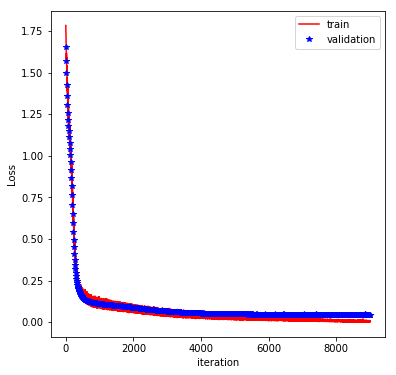

In [16]:
# Plot training and test loss
t = np.arange(iteration-1)

plt.figure(figsize = (6,6))
plt.plot(t, np.array(train_loss), 'r-', t[t % 10 == 0], np.array(validation_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

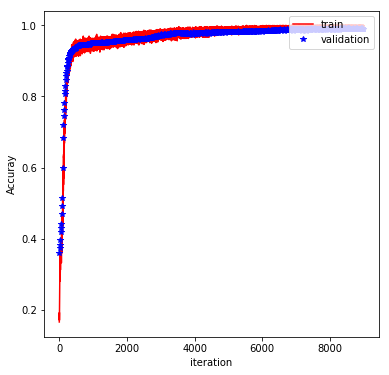

In [17]:
# Plot Accuracies
plt.figure(figsize = (6,6))

plt.plot(t, np.array(train_acc), 'r-', t[t % 10 == 0], validation_acc, 'b*')
plt.xlabel("iteration")
plt.ylabel("Accuray")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Evaluate on test set

In [18]:
test_acc = []

with tf.Session(graph=graph) as sess:
    # Restore
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints-cnn'))
    
    for x_t, y_t in get_batches(X_test, y_test, batch_size):
        feed = {inputs_: x_t,
                labels_: y_t,
                keep_prob_: 1}
        
        batch_acc = sess.run(accuracy, feed_dict=feed)
        test_acc.append(batch_acc)
    print("Test accuracy: {:.6f}".format(np.mean(test_acc)))

INFO:tensorflow:Restoring parameters from checkpoints-cnn/har.ckpt
Test accuracy: 0.906250
